# Gestion de risques de portefeuille

Cheryl Kouadio  
2025-01-27

Pour gérer les risques, on procède en trois étapes : 1. Identification :
Nous avons un portefeuille d’action, donc le risque auquel on fait face
est le risque de marché action.

1.  Metrique de risque : Volatilité ex-ante, Value at Risk ex-ante,
    Tracking error ex-ante (i.e. par anticipation, on se base sur l’état
    du portefeuille à l’instant t et non aux instants passés - ex-post)

2.  Encadrement

Dans notre cas, on va constituer le portefeuille avec 10 actifs du CAC
40 de notre choix et leur allouer des poids aléatoires :

In [1]:
# ! pip install yfinance
from datetime import datetime, timedelta
import yfinance as yf 
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

/Users/cherylkouadio/Documents/Repositories/personal-website/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(

In [2]:
def get_data(start_date, end_date, index_ticker, tickers):
    """
    Extraction de données de cours d'actions
    Args:
        start_date (str): Date de début au format 'YYYY-MM-DD'.
        end_date (str): Date de fin au format 'YYYY-MM-DD'.

    Returns:
        dict: Contient les prix historiques des indices
    """
    # Extraction des prix historiques des composants
    data = yf.download(tickers, start=start_date, end=end_date, auto_adjust =True)['Close']

    # Extraction des prix historiques de l'indice CAC 40
    index = yf.download(index_ticker, start=start_date, end=end_date, auto_adjust =True)['Close']

    return {
        "portfolio_data": data,
        "benchmark_data": index,
    }

In [3]:
end_date = datetime.now()
start_date = end_date - timedelta(days=2*365)

selected_assets = {
    "SAN.PA" : "Sanofi",
    "GLE.PA" : "Société générale",
    "HO.PA" : "Thales",
    "ENGI.PA" : "Engie",
    "CAP.PA" : "Capgemini",
    "CA.PA" : "Carrefour",
    "ORA.PA" : "Orange",
    "AC.PA" : "Accor",
    "OR.PA" : "L'Oreal",
    "ACA.PA" : "Crédit agricole"
}

index = "^FCHI"

assets_ticker  = list(selected_assets.keys())

data = get_data(start_date,end_date, index, assets_ticker)

[                       0%                       ][**********            20%                       ]  2 of 10 completed[**********            20%                       ]  2 of 10 completed[**********            20%                       ]  2 of 10 completed[**********            20%                       ]  2 of 10 completed[**********************60%****                   ]  6 of 10 completed[**********************70%*********              ]  7 of 10 completed[**********************80%*************          ]  8 of 10 completed[**********************90%******************     ]  9 of 10 completed[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed

In [4]:
portfolio_data = data["portfolio_data"]
portfolio_data.head()

In [5]:
benchmark_data = data["benchmark_data"]
benchmark_data.head()

In [6]:
# On attribue des poids équitables pour chaque action
weights_by_asset = {ticker: 1 / len(assets_ticker) for ticker in assets_ticker}

On souhaite connaitre la valeur totale du actifs du portefeuille,
i.e. l’asset under management(AUM) :

$$
AUM(T_n) = \sum_{i=1}^{10} \omega_i \times P_i(T_n)
$$

In [7]:
aum_series = portfolio_data.apply(lambda row: sum(weights_by_asset[ticker] * row[ticker] for ticker in weights_by_asset), axis=1)
aum_series

AUM = pd.DataFrame(aum_series, columns=["AUM"])

In [8]:
AUM.head()

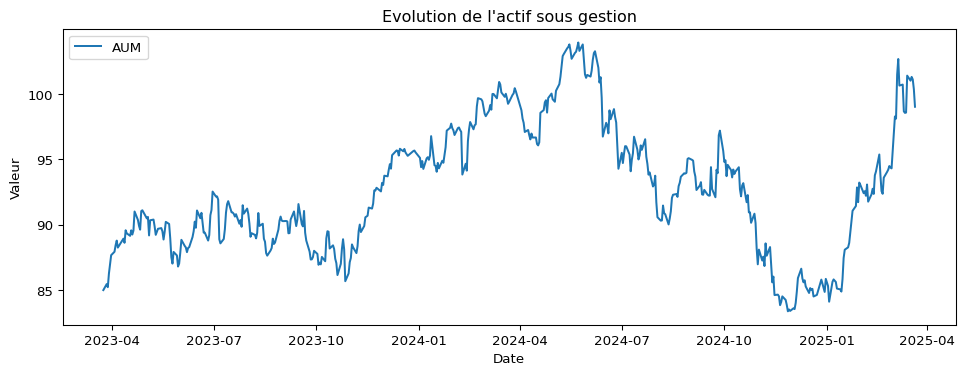

In [9]:
# Evolution de la valeur totale du portefeuille

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(AUM, label="AUM")
plt.title("Evolution de l'actif sous gestion")
plt.xlabel("Date")
plt.ylabel("Valeur")
plt.legend()

plt.show()

In [10]:
# On s'interesse aux variations/rendements de l'AUM

AUM["Variation"] = AUM["AUM"].pct_change()
AUM["Variation"].head()

Date
2023-03-24         NaN
2023-03-27    0.005417
2023-03-28   -0.002790
2023-03-29    0.012229
2023-03-30    0.008187
Name: Variation, dtype: float64

### Estimation de la volatilité

Pour estimer la volatilité du portefeuille, on peut calculer
l’écart-type des variations de l’AUM. On fait le choix de calculer une
volatilité ex-ante en se basant sur les variation historiques des prix
des actifs avec une profondeur historique de 2 ans. Vu qu’on a une
volatilité quotidienne, on va l’annualiser en multipliant par
$\sqrt{252}$.

En général, sur le marché action, la volatilité quotidienne est environ
de 1% et la volatilité annuelle est entre 10% et 20%.

In [11]:
# Calcul de la volatilité du portefeuille
volatility_portfolio = np.std(AUM["Variation"])
annualized_volatility_portfolio = volatility_portfolio * np.sqrt(252)
print(f"Volatilité de la performance quotidienne : {volatility_portfolio : .2%}")
print(f"Volatilité de la performance annuelle : {annualized_volatility_portfolio : .2%}")

Volatilité de la performance quotidienne :  0.90%
Volatilité de la performance annuelle :  14.30%

In [12]:
# Calcul de la volatilité de l'indice CAC 40

benchmark_data["Variation"] = benchmark_data["^FCHI"].pct_change()
volatility_benchmark = np.std(benchmark_data["Variation"])
annualized_volatility_benchmark = volatility_benchmark * np.sqrt(252)

print(f"Volatilité de l'indice CAC 40 : {volatility_benchmark : .2%}")
print(f"Volatilité de l'indice CAC 40 annuelle : {annualized_volatility_benchmark : .2%}")

Volatilité de l'indice CAC 40 :  0.81%
Volatilité de l'indice CAC 40 annuelle :  12.79%

On retrouve sur à peu près la même volatilité du portefeuille et celle
du CAC 40. Il y a donc une certaine homogénéité.

### Estimation de la tracking error/erreur de suivi

La tracking error est une mesure de l’écart entre la performance d’un
portefeuille et celle de son indice de référence. Elle est calculée
comme la volatilité de la différence entre les rendements du
portefeuille et de l’indice de référence :

$$
TE = \sqrt{Var(R_p - R_b)}
$$

La tracking error mesure l’incercitude du portefeuille par rapport à
l’indice de référence, c’est une mesure relative. Plus la tracking error
est élevée, plus le portefeuille est risqué. On ne souhaite sous ou
sur-performer l’indice de référence. On souhaite suivre véritablement
l’indice de référence.

Pour l’annualiser, on multiplie par $\sqrt{252}$ en supposant que les
performances quotidiennes sont indépendantes et donc un utilise
l’additivité des variances.

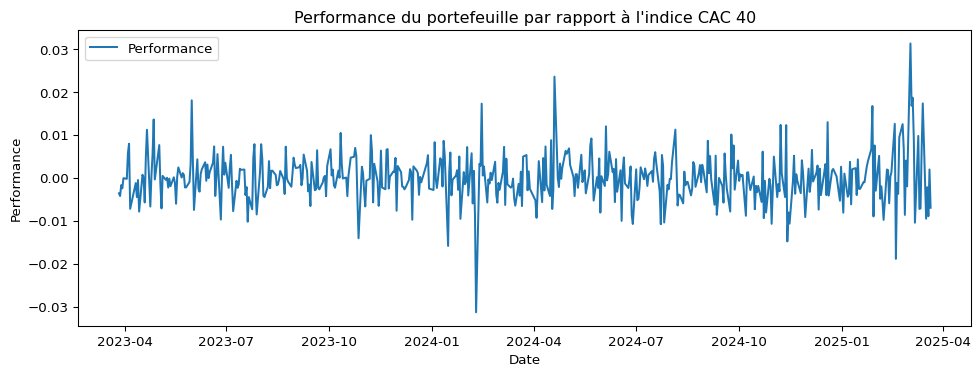

In [13]:
performance_relative = AUM["Variation"] - benchmark_data["Variation"]

plt.figure(figsize=(12, 4))
plt.plot(performance_relative, label="Performance")
plt.title("Performance du portefeuille par rapport à l'indice CAC 40")
plt.xlabel("Date")
plt.ylabel("Performance")
plt.legend()

plt.show()

In [14]:
# Calcul de la tracking error

TE = np.std(AUM["Variation"] - benchmark_data["Variation"]) 
print(f"Tracking error : {TE : .2%}")

TE_annualized = TE * np.sqrt(252)
print(f"Tracking error annualisé : {TE_annualized : .2%}")

Tracking error :  0.56%
Tracking error annualisé :  8.95%

### Estimation de la Value-at-Risk (VaR)

La VaR est une mesure de risque qui donne une estimation de la perte
maximale que l’on peut subir avec un certain niveau de confiance
$\alpha$ sur un horizon de temps donné. Par exemple, une VaR à 5% sur 1
jour de 1000 euros signifie que 95% du temps, on ne perdra pas plus de
1000 euros sur un jour.

$$P(\text{Loss} < \text{VaR}) = \alpha.$$

On peut également raisonner en terme de gain, i.e. Profit and Loss
(PnL).

$$P(\text{PnL} > - \text{VaR}) = \alpha.$$

La VaR peut se calculer suivant trois approches : 1. **Approche
historique** : On se base sur les rendements passés selon l’horizon fixé
pour estimer la VaR, à l’aide d’un quantile empirique d’ordre $\alpha$.
Autrement, on peut se baser sur les rendements journaliers et utiliser
la méthode de **rescaling**,
i.e. $VaR = \sigma \times \Phi^{-1}(\alpha)$. 2. **Approche
paramétrique** : On suppose que les rendements suivent une loi normale.
3. **Approche Monte Carlo** : On simule les rendements futurs.

In [15]:
# VaR historique
seuil = 99/100

VaR_hist_portfolio = np.percentile(AUM["Variation"].dropna(), 100*(1- seuil))
print(f"VaR historique sur le portefeuille : {- VaR_hist_portfolio : .2%}")
print(f"VaR historique sur 20 jours sur le portefeuille : {-VaR_hist_portfolio*np.sqrt(20) : .2%}")

print("\n","=*="*10,"\n")
VaR_hist_benchmark = np.percentile(benchmark_data["Variation"].dropna(), 100*(1 - seuil))
print(f"VaR historique sur l'indice CAC 40 : {-VaR_hist_benchmark : .2%}")
print(f"VaR historique sur 20 jours sur l'indice CAC 40 : {-VaR_hist_benchmark*np.sqrt(20) : .2%}")

VaR historique sur le portefeuille :  2.17%
VaR historique sur 20 jours sur le portefeuille :  9.71%

 =*==*==*==*==*==*==*==*==*==*= 

VaR historique sur l'indice CAC 40 :  1.98%
VaR historique sur 20 jours sur l'indice CAC 40 :  8.87%

In [16]:
# VaR paramétrique
# PnL ~ N(mu, sigma) ==> PnL = mu + sigma * Z, où Z ~ N(0,1)
# P(PnL > -VaR) = alpha <=> P(mu + sigma * Z > -VaR) = alpha <=> P(Z < (-VaR - mu) / sigma) = 1 - alpha
# Donc, -VaR = mu + sigma * quantile(1 - alpha), où quantile(1 - alpha) est le quantile de la loi normale standard

from scipy.stats import norm

mu = np.mean(AUM["Variation"].dropna())
print(f"mu sur le portefeuille : {mu : .2}")
sigma = np.std(AUM["Variation"].dropna())
print(f"sigma sur le portefeuille : {sigma : .2}")

VaR_param_portfolio  = -(mu + sigma * norm.ppf(1 - seuil))

print(f"VaR paramétrique sur le portefeuille : {VaR_param_portfolio : .2%}")
print(f"VaR paramétrique sur 20 jours sur le portefeuille : {VaR_param_portfolio * np.sqrt(20): .2%}")

print("\n","=*="*10,"\n")

mu = np.mean(benchmark_data["Variation"].dropna())
print(f"mu sur le benchmark: {mu : .2}")
sigma = np.std(benchmark_data["Variation"].dropna())
print(f"sigma sur le benchmark : {sigma : .2}")

VaR_param_benchmark  = -(mu + sigma * norm.ppf(1 - seuil))

print(f"VaR paramétrique sur le portefeuille : {VaR_param_benchmark : .2%}")
print(f"VaR paramétrique sur 20 jours sur le portefeuille : {VaR_param_benchmark * np.sqrt(20): .2%}")

mu sur le portefeuille :  0.00034
sigma sur le portefeuille :  0.009
VaR paramétrique sur le portefeuille :  2.06%
VaR paramétrique sur 20 jours sur le portefeuille :  9.22%

 =*==*==*==*==*==*==*==*==*==*= 

mu sur le benchmark:  0.0003
sigma sur le benchmark :  0.0081
VaR paramétrique sur le portefeuille :  1.84%
VaR paramétrique sur 20 jours sur le portefeuille :  8.25%

La VaR relative suit une philosophie proche du tracking error. Elle se
calcule sur les écarts entre le portefeuille et le benchmark. Elle sert
à mesurer de combien mon portefeuille sous-performe par rapport à
l’indice de référence.

In [17]:
performance_relative


VaR_hist_relative = np.percentile(performance_relative.dropna(), 100*(1- seuil))
print(f"VaR historique relative : {- VaR_hist_relative : .2%}")
print(f"VaR historique relative sur 20 jours : {-VaR_hist_relative*np.sqrt(20) : .2%}")

print("\n","=*="*10,"\n")

mu = np.mean(performance_relative.dropna())
print(f"mu des performances relatives: {mu : .2}")
sigma = np.std(performance_relative.dropna())
print(f"sigma des performances relatives : {sigma : .2}")

VaR_param_relative  = -(mu + sigma * norm.ppf(1 - seuil))

print(f"VaR paramétrique relative : {VaR_param_relative : .2%}")
print(f"VaR paramétrique relative sur 20 jours : {VaR_param_relative * np.sqrt(20): .2%}")

VaR historique relative :  1.08%
VaR historique relative sur 20 jours :  4.82%

 =*==*==*==*==*==*==*==*==*==*= 

mu des performances relatives:  4e-05
sigma des performances relatives :  0.0056
VaR paramétrique relative :  1.31%
VaR paramétrique relative sur 20 jours :  5.85%

# Stress test

Les stress test permettent de tester les performances du portefeuille
dans des conditions extrêmes. Ils sont de deux natures : 1. Stress test
historique : On soumet le portefeuille à une période historique ou on
estime avoir eu une condition extrême (Covid, Subprime crisis). On
rejoue un scénario qui s’est déjà passé.

1.  Stress test hypothétique : On joue un scénario qui ne s’est jamais
    réalisé. Exemple, si les actions chutent de 40%, notre portefeuille
    d’action chute de 40%.

*Note : **bp** = 0,01%*

In [18]:
# Recuperons les prix des actifs le 19/02/2020 et le 18/03/2020
# On va valoriser notre portefeuille à ces dates et calculer les performances
# A ces dates, le CAC 40 a connu de fortes pertes pendant la COVID-19
# data_1902 = get_data

start_date = pd.to_datetime("19-02-2020", dayfirst=True)
end_date = start_date + timedelta(days=1)


data_1902 = get_data(start_date,end_date, index, assets_ticker)
portfolio_data_1902=data_1902["portfolio_data"]
benchmark_data_1902=data_1902['benchmark_data']

start_date = pd.to_datetime("18-03-2020", dayfirst=True)
end_date = start_date + timedelta(days=1)


data_1803 = get_data(start_date,end_date, index, assets_ticker)
portfolio_data_1803=data_1803["portfolio_data"]
benchmark_data_1803=data_1803['benchmark_data']

# Concaténer les données des deux dates pour le portefeuille et le benchmark
portfolio_data_stress = pd.concat([portfolio_data_1902, portfolio_data_1803], ignore_index=False)
benchmark_data_stress = pd.concat([benchmark_data_1902, benchmark_data_1803], ignore_index=False)

[                       0%                       ][**********            20%                       ]  2 of 10 completed[**************        30%                       ]  3 of 10 completed[**************        30%                       ]  3 of 10 completed[**********************50%                       ]  5 of 10 completed[**********************60%****                   ]  6 of 10 completed[**********************70%*********              ]  7 of 10 completed[**********************80%*************          ]  8 of 10 completed[**********************90%******************     ]  9 of 10 completed[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed
[                       0%                       ][                       0%                       ][                       0%                       ][                       0%                       ][                       0%                       ][       

In [19]:
# Stress test covid sur le portefeuille
aum_series_stress = portfolio_data_stress.apply(lambda row: sum(weights_by_asset[ticker] * row[ticker] for ticker in weights_by_asset), axis=1)

AUM_stress = pd.DataFrame(aum_series_stress, columns=["AUM"])
AUM_stress["Variation"] = AUM_stress["AUM"].pct_change()

AUM_stress

In [20]:
benchmark_data_stress["Variation"]=benchmark_data_stress["^FCHI"].pct_change()
benchmark_data_stress

Notre portefeuille permet de mieux resister au stress test covid que le
CAC 40.